# ML analysis and DI estimation

In this notebook, the damage index is estimated using a machine learning algorithm and an adequately chosen feature set.

### Importing necessary libraries

In [2]:
import json
import os
from sklearn.model_selection import train_test_split
from ml_tools.analyzers import Reader, Writer
from ml_tools.plots import ParetoPlotter, RealPredictedPlotter
from ml_tools.predictor import Predictor
from ml_tools.helpers import create_simulation, get_processed_data_from_csv
from ml_tools.trainer import Trainer
from config import FeatureConfigReader, ModelsConfig, Config

### Define paths to JSON and CSV Files

To set up the models and each feature used in the investigation, JSON config files are used.

The main data file is [data_P3.csv](CSV_files/data_P3.csv).

- **"[comparison_V2.json](config/comparison.json)":** Used for comparing ML algorithms with different hyperparameters.
- **"[features_V2.json](config/features.json)":** Used to define model features.
- **"[models_V2.json](config/models.json)":** Used to define different ML algorithms employed in this project, specifically "K Nearest Neighbours", "gradient boosting", "SVR", and "random forrest" along with the Pareto Legend.
- **"[data_P3.csv](CSV_files/data_P3.csv)":** Contains damage index simulation results.




In [3]:
comparison_config_file_name = os.path.join("config", "comparison_V2.json")
features_config_file_name = os.path.join("config", "features_v2.json")
models_config_file_name = os.path.join("config", "models_V2.json")
data_file_name = os.path.join("CSV_files", "data_P3.csv")
results_file_name = "results_comparison"
scaler_options = ["min-max scale"]
ALL_FEATURES_COUNT = 23

### Extract features and models from config files

In [4]:
models_config = ModelsConfig(models_config_file_name)
models = models_config.get_model_names()
print(models_config.config_data)  # Pentru a verifica datele încărcate
features_config = FeatureConfigReader(features_config_file_name)
print(features_config)  # Afișează lista de modele
best_features_by_set = features_config.get_all_features_dictionary()

{'models': {'K Nearest Neighbours': {'no_hyper_params': {}, 'with_hyper_params_optimisation': {'n_neighbors': [3, 5, 11, 15], 'weights': ['uniform', 'distance']}, 'pareto_color_no_hyper_params': 'green', 'pareto_color_with_hyper_params': 'blue'}, 'gradient boosting': {'no_hyper_params': {}, 'with_hyper_params_optimisation': {'n_estimators': [100, 300, 500], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7, 9]}, 'pareto_color_no_hyper_params': 'orange', 'pareto_color_with_hyper_params': 'blue'}, 'svr': {'no_hyper_params': {}, 'with_hyper_params_optimisation': {'C': [0.01, 0.1], 'epsilon': [0.001, 0.01]}, 'pareto_color_no_hyper_params': 'purple', 'pareto_color_with_hyper_params': 'blue'}, 'random forrest': {'no_hyper_params': {}, 'with_hyper_params_optimisation': {'n_estimators': [100, 300], 'max_depth': [None, 10, 30]}, 'pareto_color_no_hyper_params': 'purple', 'pareto_color_with_hyper_params': 'blue'}}}


### Initialize data storage dictionaries and lists

These data structures are used for visually representing results.

In [5]:
pareto_data_sets = { 'R2 vs. MAE': { 'R2' : [], 'MAE' : [] },
                        'MAE vs. FUR': { 'MAE' : [], 'FUR' : [] },
                        'R2 vs. FUR': { 'R2' : [], 'FUR' : [] }}

legend_elements = []
markers = []
colors = []
readers = []

### Creating a general configuration file for investigated simulation experiments

For each model-feature set pair, a configuration is developed.

In [7]:
def create_simulations_config_file(features_set):
    base_simulation = {
        "description": features_set,
        "features": [],
        "model": {
            "type": "",
            "hyper_parameters": {}
        }
    }

    all_simulations = {"simulations": {}}
    simulation_count = 1

    for model in models:
        options = ["no_hyper_params"] if "regression" in model else ["no_hyper_params", "with_hyper_params_optimisation"]

        for option in options:
            
            current_simulation  = create_simulation(base_simulation, features, model, option, models_config)
            
            # Add the current_simulation dictionary to the all_simulations dictionary
            all_simulations["simulations"][f"simulation {simulation_count} {features_set}"] = current_simulation
            
            simulation_count += 1

    with open(comparison_config_file_name, "w") as f:
        json.dump(all_simulations, f, indent=4)

### Utility function for bi-dimensional representation of results

Since results will be plotted considering several indicators, a processing function is used to return an uniform value considering the axis of the respective plot.

In [8]:
def get_value_for_pareto_plot(reader, indicator, data_type):
    for performance in reader.performances:
        if performance.indicator == indicator and performance.data_type == data_type:
            if indicator == "R2":
                return (1-performance.value)
            else:
                return performance.value
    return None

### Training and testing the model on the predefined feature sets

All simulation scenarios configured in the main file are executed.

In each scenario, a model is trained on a training data set and tested afterwards on a test data set.

For each scenario, performances are represented graphically.


---------------------------
K Nearest Neighbours: MAE (test): 0.07 | MSE (test): 0.04 | R2 (test): 0.84 | MAE (train): 0.05 | MSE (train): 0.02 | R2 (train): 0.9 | 


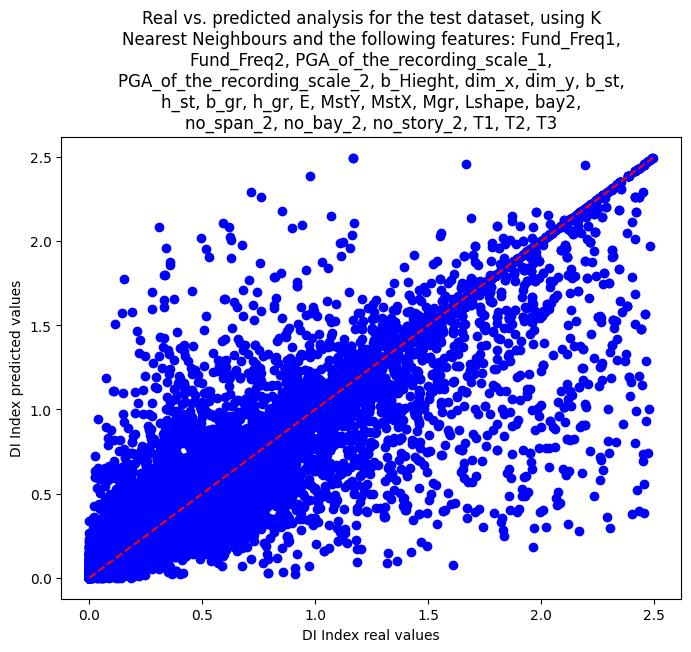

---------------------------
Optimised K Nearest Neighbours: MAE (test): 0.04 | MSE (test): 0.02 | R2 (test): 0.9 | MAE (train): 0.0 | MSE (train): 0.0 | R2 (train): 1.0 | 


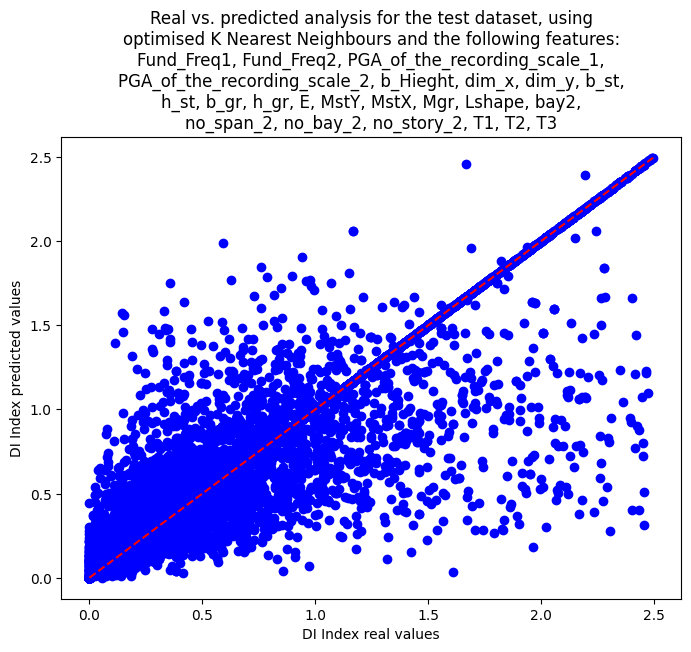

---------------------------
Gradient boosting: MAE (test): 0.17 | MSE (test): 0.06 | R2 (test): 0.73 | MAE (train): 0.16 | MSE (train): 0.06 | R2 (train): 0.73 | 


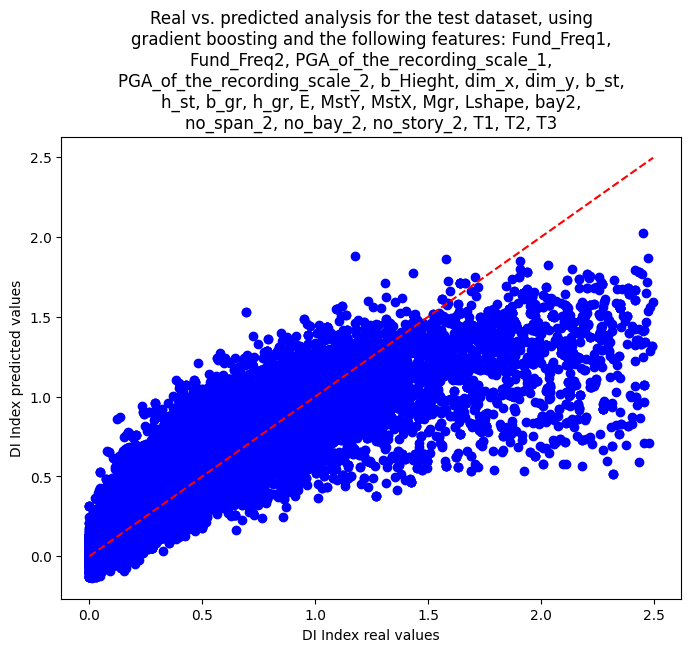

---------------------------
Optimised Gradient boosting: MAE (test): 0.03 | MSE (test): 0.01 | R2 (test): 0.97 | MAE (train): 0.02 | MSE (train): 0.0 | R2 (train): 1.0 | 


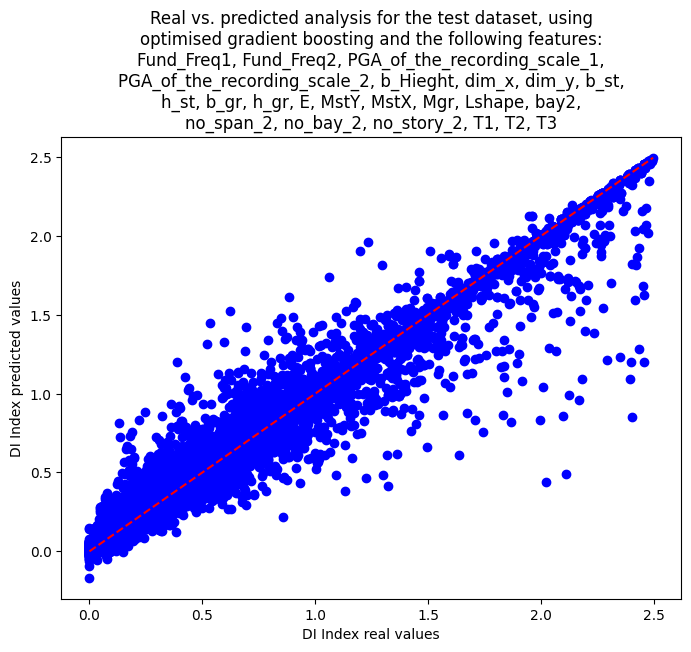

---------------------------
Optimised SV regression: MAE (test): 0.21 | MSE (test): 0.11 | R2 (test): 0.52 | MAE (train): 0.21 | MSE (train): 0.11 | R2 (train): 0.52 | 


c:\Users\Vasile Calofir-ED115\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


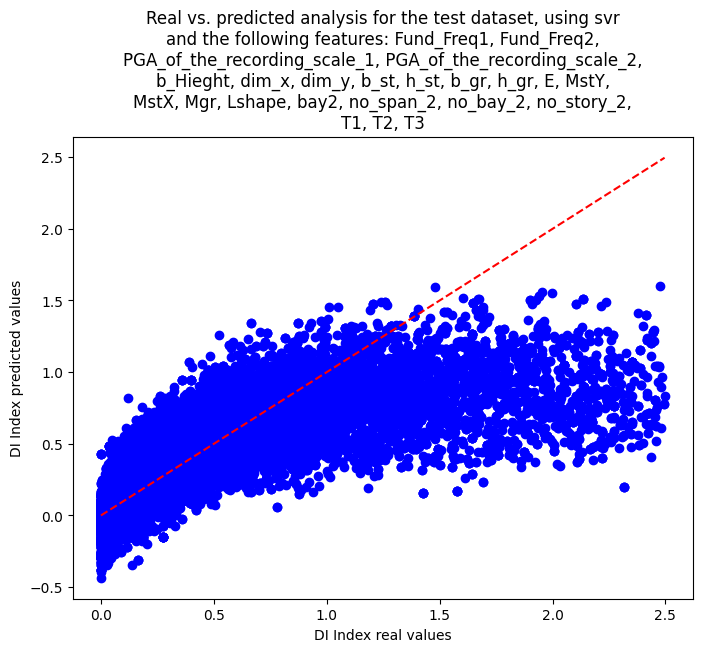

---------------------------
SV regression: MAE (test): 0.21 | MSE (test): 0.11 | R2 (test): 0.51 | MAE (train): 0.21 | MSE (train): 0.11 | R2 (train): 0.52 | 


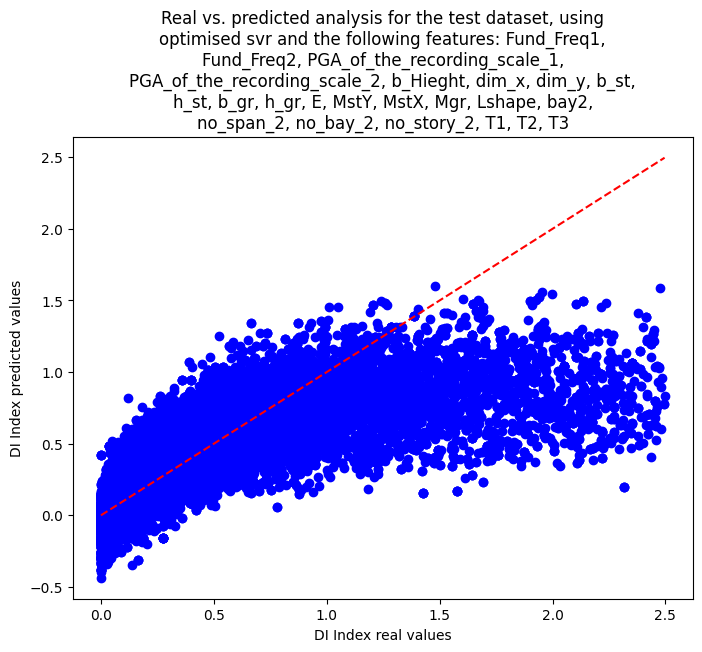

---------------------------
Random forrest: MAE (test): 0.03 | MSE (test): 0.01 | R2 (test): 0.96 | MAE (train): 0.01 | MSE (train): 0.0 | R2 (train): 0.99 | 


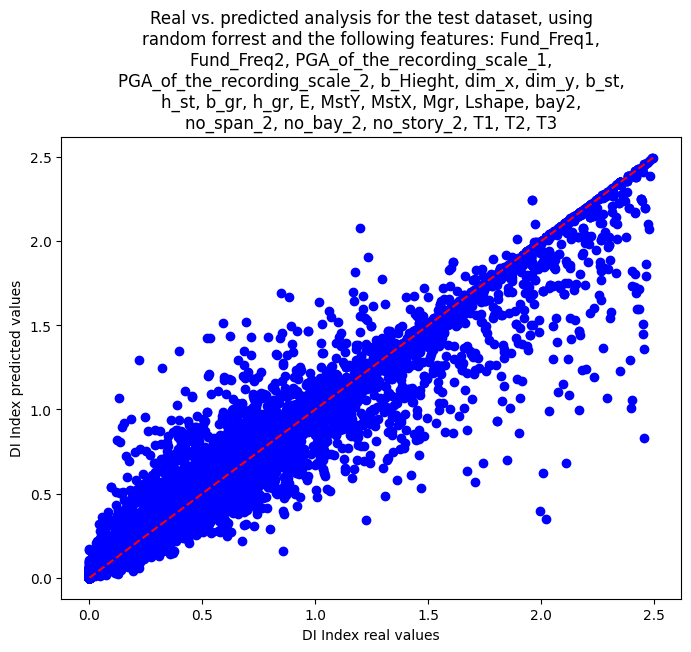

---------------------------
Optimised Random forrest: MAE (test): 0.03 | MSE (test): 0.01 | R2 (test): 0.96 | MAE (train): 0.01 | MSE (train): 0.0 | R2 (train): 0.99 | 


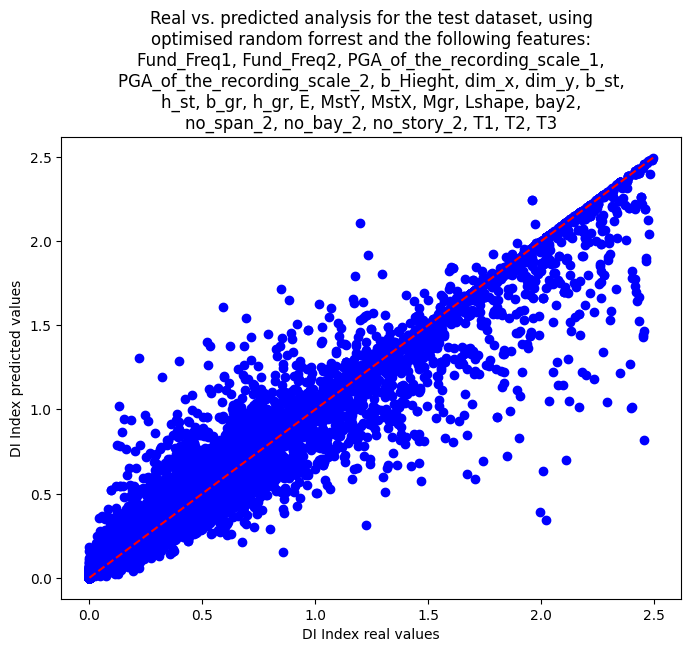

In [7]:
for features_set, features in best_features_by_set.items():

    create_simulations_config_file(features_set)

    # Machine learning analysis
    processed_data = get_processed_data_from_csv(data_file_name)

    y = processed_data['DI_cladire'] 

    config = Config(comparison_config_file_name)
    
    simulations = config.get_simulations()
    
    for simulation in simulations:

        selected_features = config.get_features(simulation)
        x = processed_data[selected_features]
        model_type = config.get_model_type(simulation)
        hyper_params = config.get_hyper_parameters(simulation)
        
        if hyper_params:
            option = "with hyper-params"
        else:
            option = ""
        
        if "min-max scale" in scaler_options:
            trainer = Trainer(x, y, model_type, hyper_params, use_min_max_scale=True)
        else:
            trainer = Trainer(x, y, model_type, hyper_params)
        trainer.set_train_test_data(test_size=0.2)
        trainer.train_model()
        
        predictor = Predictor(trainer)
        predictor.set_prediction_on_test()
        predictor.set_prediction_on_train()

        reader = Reader(simulation, trainer, predictor)
        reader.set_performances_on_test_data()
        reader.set_performances_on_train_data()

        print("---------------------------")
        reader.print_performances()
        readers.append(reader)
        
        writer = Writer(config, simulation,reader.performances, results_file_name)
        writer.append_to_csv()
        
        # Collecting performance data for plotting
        pareto_data_sets["R2 vs. MAE"]["R2"].append(get_value_for_pareto_plot(reader, "R2", "test"))
        pareto_data_sets["R2 vs. MAE"]["MAE"].append(get_value_for_pareto_plot(reader, "MAE", "test"))
        pareto_data_sets["R2 vs. FUR"]["R2"].append(get_value_for_pareto_plot(reader, "R2", "test"))
        pareto_data_sets["R2 vs. FUR"]["FUR"].append(len(features)/ALL_FEATURES_COUNT)
        pareto_data_sets["MAE vs. FUR"]["MAE"].append(get_value_for_pareto_plot(reader, "MAE", "test"))
        pareto_data_sets["MAE vs. FUR"]["FUR"].append(len(features)/ALL_FEATURES_COUNT)
        
        legend_elements.append(f"{model_type} {option}, {features_set}")
        
        marker = features_config.get_pareto_marker(features_set)
        markers.append(marker)  
        
        color = models_config.get_pareto_color(model_type, option)
        colors.append(color) 
        
        plotter = RealPredictedPlotter(config, "figs", False, simulation, features_set, features, trainer, predictor)
        plotter.generate_plot()

### Generate global bi-dimensional comaprisons

All pairs containg a model and a feature set are represented in bi-dimensional plots considering several indicators like R2 score, MAE and Feature Usage Rate (FUR). 

In each case, the origin of the plot represents an ideal case where the indicators are maximised.

The closer the scenario is to the origin of the plot, the better the performance.

One can choose "False" as the second argument in the ParetoPlotter to display figures instead of saving them.

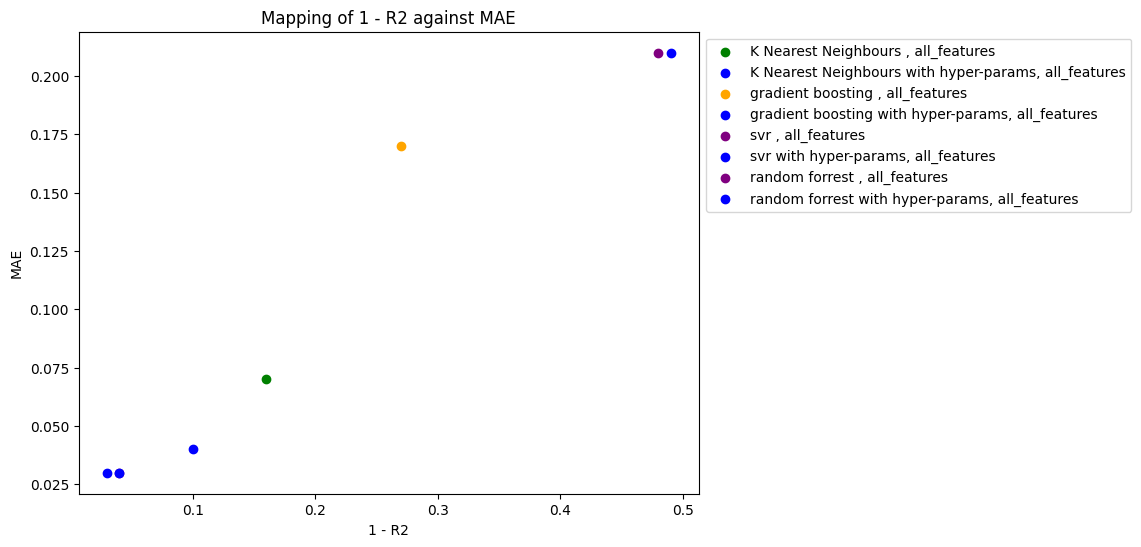

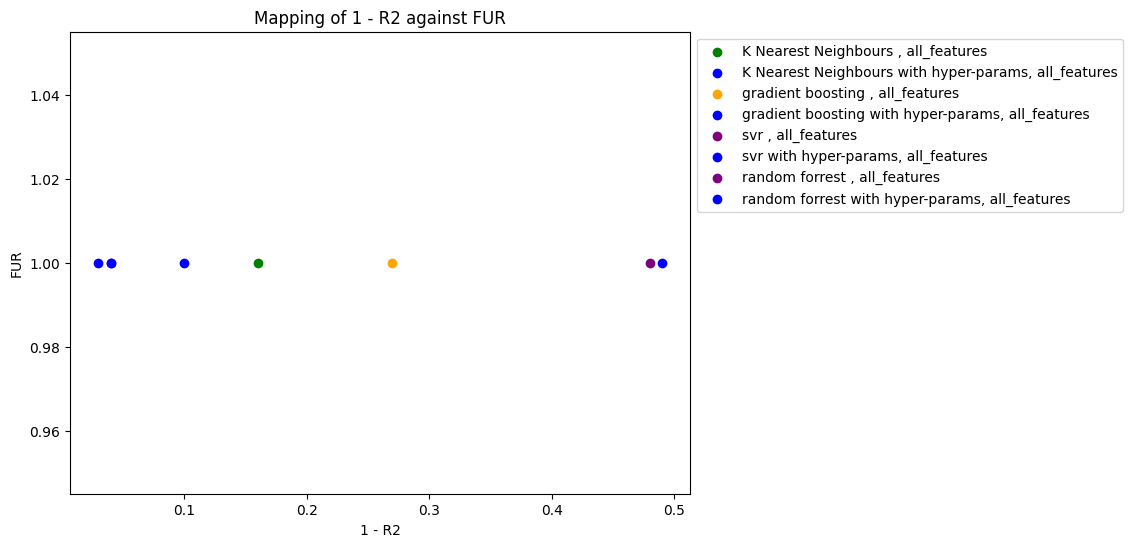

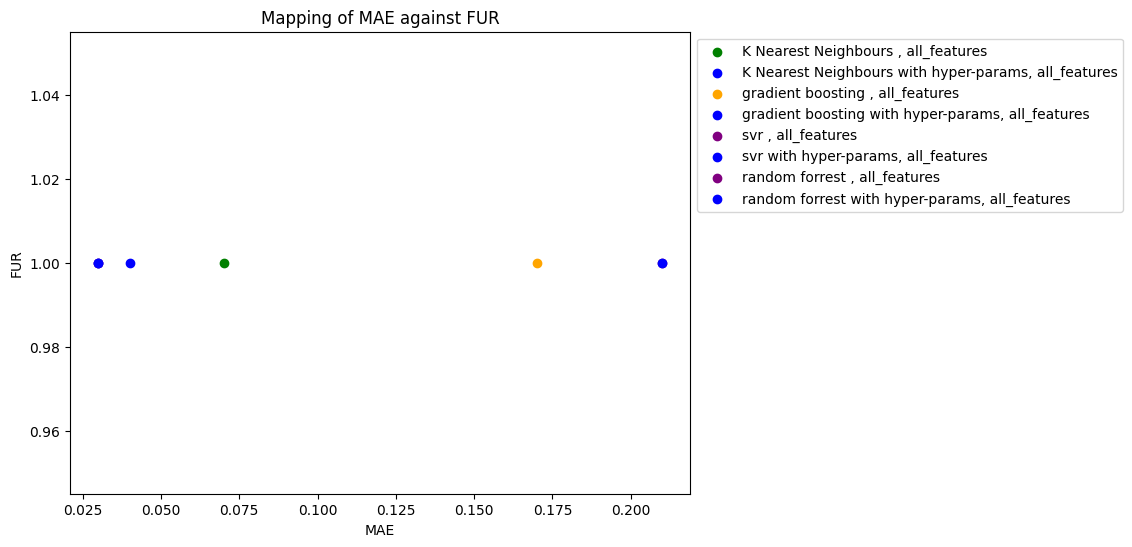

In [8]:
plotter = ParetoPlotter("figs", False, pareto_data_sets["R2 vs. MAE"]["R2"], 
                        pareto_data_sets["R2 vs. MAE"]["MAE"], 
                        "1 - R2", "MAE", legend_elements, markers, colors)
plotter.generate_plot()    

plotter = ParetoPlotter("figs", False, pareto_data_sets["R2 vs. FUR"]["R2"], 
                        pareto_data_sets["R2 vs. FUR"]["FUR"], 
                        "1 - R2", "FUR", legend_elements, markers, colors)
plotter.generate_plot()    

plotter = ParetoPlotter("figs", False, pareto_data_sets["MAE vs. FUR"]["MAE"], 
                        pareto_data_sets["MAE vs. FUR"]["FUR"], 
                        "MAE", "FUR", legend_elements, markers, colors)
plotter.generate_plot() 